# 9 - Destructive interference

In the last tutorial we observed speed-ups in radiation and excitation transfer rates as a result of the delocalisation of excitations across many TLS. We understood these rate accelerations to be a result of the constructive interference of many quantum pathways.

In this tutorial, we'll look at the other side of the coin - destructive interference. 

In [179]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import Video

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# The helper file below brings functions created in previous tutorials
from libs.helper_09_tutorial import *

## 9.1 - Recap
Last time, we described delocalised excitations transferring from one "place" to another by breaking the overall system into 2 parts - system A and system B. Each system can in principle have its own number of TLS ($N_A$, $N_B$) and its own number of excitations ($n_{+A}$, $n_{+B}$). 

The general Hamiltonian for this AB situation is described by:

$$H =  \Delta E_A J_{N_Az}^{(A)} + \Delta E_B J_{N_Bz}^{(B)} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U_A\left( a^{\dagger} + a \right)2J_{N_Ax}^{(A)} + U_B\left( a^{\dagger} + a \right)2J_{N_Bx}^{(B)}$$

We focused on the case where:
- System A and B have the same transition energy: $ \Delta E_A =  \Delta E_B =  \Delta E$
- System A and B couple to the boson field in the same way: $U_A = U_B = U$
- System A and B consist of the same number ot TLS: $N_A = N_B = N$

We'll continue that focus in this tutorial.

In [2]:
H_latex_AB = "$H = \Delta E (J_{Nz}^{(A)}+J_{Nz}^{(B)}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2(J_{Nx}^{(A)} + J_{Nx}^{(B)})$ "

We'll bring over the `make_operators_AB` from the last tutorial.

In [3]:
def make_operators_AB(max_bosons=2, parity=0, num_TLS_A=1, num_TLS_B=1):

    jmax_A = num_TLS_A/2              # max j gives us Dicke states
    jmax_B = num_TLS_B/2              # max j gives us Dicke states
    
    J_A     = jmat(jmax_A)
    J_B     = jmat(jmax_B)
    Jx_A    = tensor(qeye(max_bosons+1), J_A[0], qeye(J_B[0].dims[0][0]))                                     # tensorised JxA operator
    Jz_A    = tensor(qeye(max_bosons+1), J_A[2], qeye(J_B[0].dims[0][0]))                                     # tensorised JzA operator
    Jx_B    = tensor(qeye(max_bosons+1), qeye(J_A[0].dims[0][0]), J_B[0])                                     # tensorised JxB operator
    Jz_B    = tensor(qeye(max_bosons+1), qeye(J_A[0].dims[0][0]), J_B[2])                                     # tensorised JzB operator
    a       = tensor(destroy(max_bosons+1), qeye(J_A[0].dims[0][0]), qeye(J_B[0].dims[0][0]))                 # tensorised boson destruction operator

    two_state_A     = Jz_A                                 # two state system energy operator   JzA
    two_state_B     = Jz_B                                 # two state system energy operator   JzB
    bosons        = (a.dag()*a+0.5)                       # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                             # boson number operator              𝑎†𝑎
    interaction_A  = 2*(a.dag() + a) * Jx_A                # interaction energy operator        2(𝑎†+𝑎)JxA 
    interaction_B  = 2*(a.dag() + a) * Jx_B                # interaction energy operator        2(𝑎†+𝑎)JxB
    
    P = (1j*np.pi*(number + Jz_A + Jz_B + (num_TLS_A + num_TLS_B)/2)).expm()    # parity operator 
    
    # map from QuTiP number states to |n,n_+A,n_+B> states
    possible_ns = range(0, max_bosons+1)
    possible_ms_A = range(int(2*jmax_A), -1, -1)
    possible_ms_B = range(int(2*jmax_B), -1, -1)
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms_A, possible_ms_B)]

    
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
    else:
        p               = np.where(P.diag()==P.diag())[0]
        
    two_state_A       = two_state_A.extract_states(p)
    two_state_B       = two_state_B.extract_states(p)
    bosons          = bosons.extract_states(p)
    number          = number.extract_states(p)
    interaction_A     = interaction_A.extract_states(p)
    interaction_B     = interaction_B.extract_states(p)
    nmm_list        = [nmm_list[i] for i in p]
  
    return two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list

In [4]:
two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list = make_operators_AB(max_bosons=1, parity=0, num_TLS_A=1, num_TLS_B=1)


In [5]:
bra_labels, ket_labels = make_braket_labels(nmm_list) 

In [6]:
H = 1*two_state_A + 1*two_state_B + 1*bosons + 1*interaction_A + 1*interaction_B

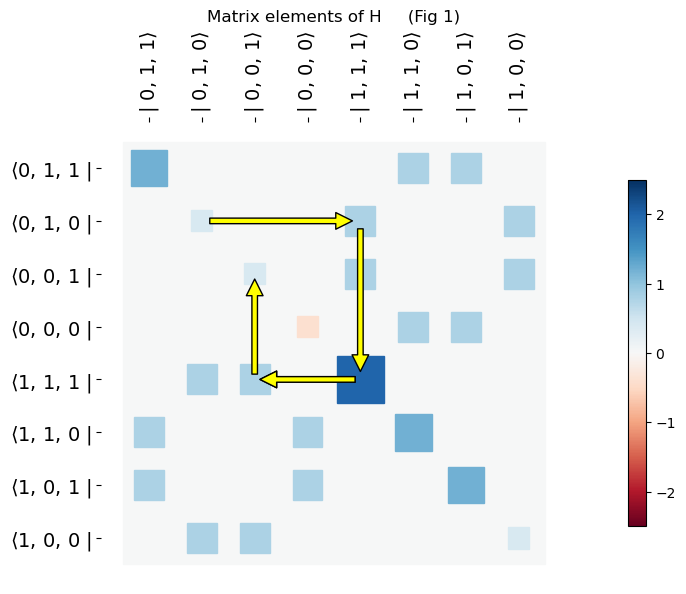

In [7]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");
ax.annotate('', xy=(4.5, 6.5), xytext=(1.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(4.5, 3.5), xytext=(4.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 3.5), xytext=(4.5, 3.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 3.5), xytext=(4.5, 3.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 5.5), xytext=(2.5, 3.5), arrowprops=dict(facecolor='yellow', shrink=0.05));


Fig 1 shows us one path for a single excitation to transfer from system A to system B, via an intermediate state. We can write this as $|0, 1, 0  \rangle \rightarrow |1, 1, 1  \rangle \rightarrow |0, 0, 1  \rangle$. It's worth noting that this intermediate state is a virtual state because it does not satisfy energy conservation properties. Sometimes we call these virtual states "off resonant" states.

We can form another path as seen below.

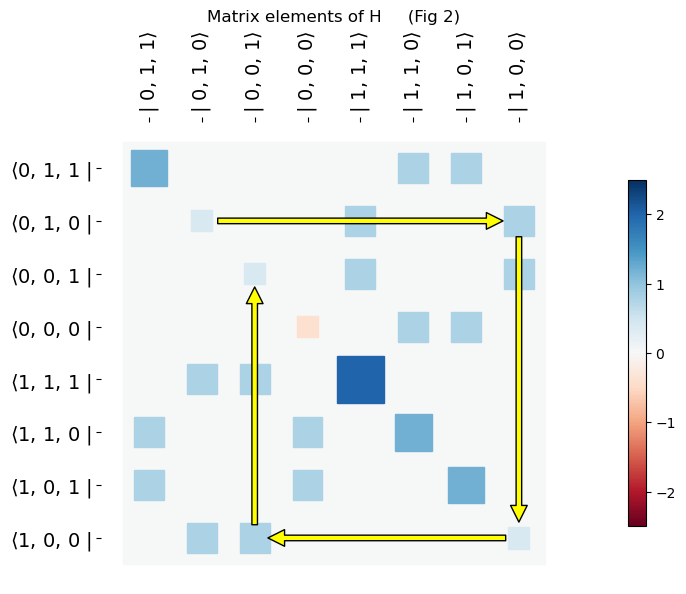

In [8]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 2)");

ax.annotate('', xy=(7.5, 6.5), xytext=(1.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(7.5, 0.5), xytext=(7.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 0.5), xytext=(7.5, 0.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 5.5), xytext=(2.5, 0.5), arrowprops=dict(facecolor='yellow', shrink=0.05));


Fig 2 shows us another path for a single excitation to transfer from system A to system B, via an intermediate state. We can write this as $|0, 1, 0  \rangle \rightarrow |1, 0, 0  \rangle \rightarrow |0, 0, 1  \rangle$. This intermediate state may be virtual (off resonant) depending on whether the TLS energy matches the boson energy.

For non radiative excitation transfer, the TLS transition energy is not matched to the boson energy. In this case, both intermediate states are off resonant and as a consequence their occupation probability is negligibly small (for small coupling). We've seen this in our first encounter with excitation transfer, but let's confirm it again below by simulation.

In [102]:
DeltaE = 10.5 # Mismatch between boson energy and the TLS energy to make sure we avoid emission
omega = 1
U = 0.01 

In [139]:
# Field in vacuum state (0) with 1 excitation in A (1) and 0 excitations in B (0)
psi0_ind = nmm_list.index((0,1,0))  
psi0 = basis(len(nmm_list), psi0_ind)

In [161]:
# We're using a very high resolution in time because we're going to be interested in looking at the wavefunction as well as the probability 
# and the wavefunction has high frequency oscillations that we want to resolve.
times = np.linspace(0,  2000000, 20000000)

In [162]:
H = DeltaE*two_state_A + DeltaE*two_state_B + omega*bosons + U*interaction_A + U*interaction_B

In [142]:
# Just like last time, we are using custom simulate function because it's going to be quicker
# in this case because of the long simulation times. Note that this still takes about 30s to run
# because of the high time resolution we've chosen for this simulation
P, psi, evals, ekets = simulate(H, psi0, times)

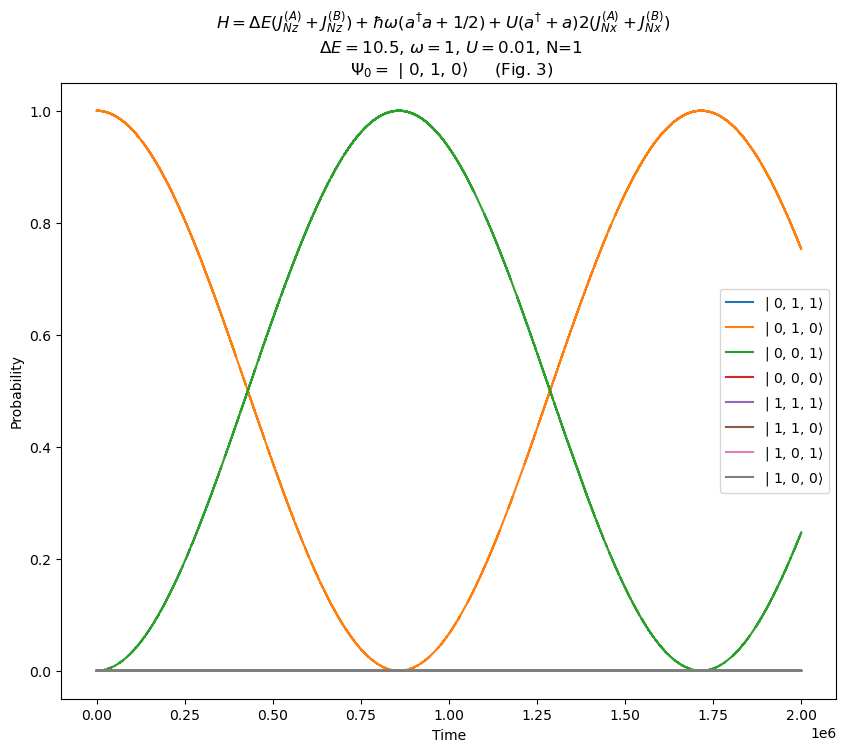

In [143]:
plot_sim(times, P, labels=ket_labels)
plt.title(f'{H_latex_AB}  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={1} \n $\Psi_0 =$ {ket_labels[psi0_ind]}     (Fig. 3)');

Fig. 3 indeed shows that there is no meaningful probability in the energy non-conserving states as one would expect.

There is however more to discover if we instead look at the wavefunctions for the intermediate states $|1, 0, 0   \rangle$ and $|1, 1, 1  \rangle$.

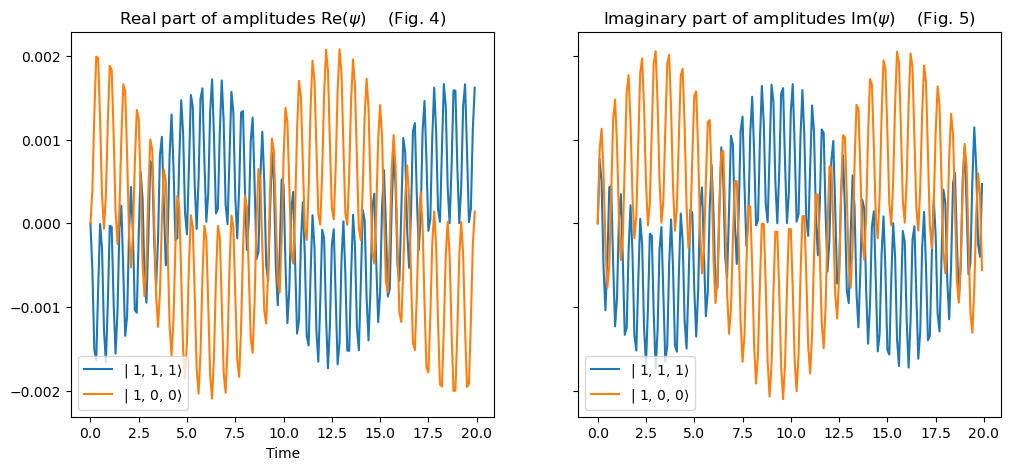

In [160]:
fig, (ax_real, ax_imag) = plt.subplots(1,2, sharey=True, figsize=(12, 5))

ax_real.plot(times[0:200],psi[4,0:200], label=ket_labels[4])
ax_real.plot(times[0:200],psi[7,0:200], label=ket_labels[7])
ax_real.set_title('Real part of amplitudes Re($\psi$)    (Fig. 4)')
ax_real.set_xlabel('Time')

ax_imag.plot(times[0:200],1j*psi[4,0:200], label=ket_labels[4])
ax_imag.plot(times[0:200],1j*psi[7,0:200], label=ket_labels[7])
ax_imag.set_title('Imaginary part of amplitudes Im($\psi$)    (Fig. 5)')


ax_real.legend()
ax_imag.legend();

Notice how in Figs. 4 and 5 how $|1, 0, 0  \rangle$ and $|1, 1, 1  \rangle$ move out of phase with each other in the sense that when one is at its maximum positive the other is at its maximum negative - they almost cancel each other out. This kind of destructive interference is the reason why the excitation transfer is in general very slow. 

It can be quite difficult to build an intuition for these kind of quantum effects, so it's helpful to try as much as possible to map our quantum problems to equivalent classical ones.

At the start of this tutorial series, we already made a connection to coupled pendulums. It turns out (quite fortunately for us) that many of our quantum problems can be mapped rigorously to such a familiar classical system. Each state is represented by a pendulum whose frequency is directly proportional to the energy of that state as given to us by the TLS Hamiltonian. The coupling between the pendulums can be quantified by inspecting the Hinton diagram as we've done above and extracting the matrix elements between the different states.
> Aside: We'll not prove all this here because it will take us to too far off track. If you're interested to go down that delightful rabbit hole then check out e.g. [Coherent quantum states from classical oscillator amplitudes
](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.85.052111) by Briggs et.al.

Let's take a look at the classical equivalent of the quantum scenario that's being simulated in Figs. 3-5 above. It maps to a 4 pendulum problem shown in Fig XXX below.

In [180]:
Video("img/pendulum_animation-destructive.mp4")

The mapping looks like this:
- $|0,+,- \rangle $ - Blue
- $|0,-,+ \rangle $ - Orange
- $|1,+,+ \rangle$ - Red
- $|1,-,- \rangle$ - Green

The blue and orange pendulums have the same length (and hence frequency) because the equivalent quantum states have the same energy. The red pendulum is shorter and hence has a higher frequency because its equivalent quantum state has both TLS in the higher energy ($+$) state. Similarly the green pendulum is shorter and hence has a lower frequency because its equivalent quantum state has both TLS in the lower energy ($-$) state. 

We see in the animation how the blue and orange pendulums are not directly coupled, but instead indirectly coupled through the red and green pendulums as is the case for our equivalent quantum problem. Despite the coupling, we see that barely any excitation transfers from the blue to the orange because the red and green are almost always completely out of phase.

> ASIDE: We'll not write all the equations for the classical case here. Note also that it's only true for small amplotude that the animation is clearly not showing. We make it big so you can see it more clearly.

In general, 4 pendulums coupled in this way will not exhibit such a high level of destructive interference. It only occurs in our case because of the very specific relationship between the frequencies that comes from the energy of the equivalent quantum states. 
> Aside: Loosely connecting the energy $E$ or the classical and quantum world for a moment, we can say that $E_{\text{red}} = 2E_{+}$, $E_{\text{green}} = 2E_{-}$, $E_{\text{blue}} = E_{\text{orange}} = E_{+} + E_{-}$. This creates the relationship $E_{\text{blue}} = E_{\text{orange}} = \frac{1}{2}(E_{\text{red}}+E_{\text{green}})$. In the pendulum world we work with the square of the frequency $\omega^2$ instead of energy and so we write $\omega^2_{\text{blue}} = \omega^2_{\text{orange}} = \frac{1}{2}(\omega^2_{\text{red}}+\omega^2_{\text{green}})$.



Let's take a closer look now at the quantum problem by reminding ourselves of the time independent Schrödinger equation

$$H\Psi = E\Psi$$

The Schrödinger equation is asking us to find states $\Psi$ that don't change under the action of the Hamiltonian $H$ other than being multiplied by a constant $E$ that we associate with the state's energy - these are called "stationary states" or "energy levels". In mathematical language we refer to $E$ and $\Psi$ as eigenvalues and eigenvectors (or eigenstates) of the Hamiltonian operator. 

As we saw in previous tutorials, studying the energy levels gave us insight into the Rabi oscillations that we see with excitation transfer. Coupling of the TLS to the field causes otherwise degenerate levels to split and it's this splitting that allows for the frequency beating that manifests as a slow transfer of excitation from one TLS to another. We've previously used QuTiP to numerically investigate the energy levels, but to understand this destructive interference business we must do some analytical work.




For our system, $\Psi$ has 8 components that must be solved for simultaneously.

$$
\Psi = \begin{pmatrix}
 \Psi_{|0,1,1\rangle}   \\
 \Psi_{|0,1,0\rangle}   \\
 \Psi_{|0,0,1\rangle}   \\
 \Psi_{|0,0,0\rangle}   \\
 \Psi_{|1,1,1\rangle}   \\
 \Psi_{|1,1,0\rangle}   \\
  \Psi_{|1,0,1\rangle}   \\
  \Psi_{|1,0,0\rangle}   \\
 \end{pmatrix}
$$

However, for our excitation transfer problem we only need to keep 4 of these components as can be seen by performing the matrix multiplication $H\Psi$ and keeping rows 2, 3, 5 and 8 associated with states $|0,1,0\rangle$, $|0,0,1\rangle$, $|1,1,1\rangle$, $|1,0,0\rangle$. If you inspect the Hamiltonian, you'll notice that these 4 states couple to each other and no others.

In [181]:
H

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.1e+01  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e-02  1.0e-02  0.0e+00]
 [ 0.0e+00  5.0e-01  0.0e+00  0.0e+00  1.0e-02  0.0e+00  0.0e+00  1.0e-02]
 [ 0.0e+00  0.0e+00  5.0e-01  0.0e+00  1.0e-02  0.0e+00  0.0e+00  1.0e-02]
 [ 0.0e+00  0.0e+00  0.0e+00 -1.0e+01  0.0e+00  1.0e-02  1.0e-02  0.0e+00]
 [ 0.0e+00  1.0e-02  1.0e-02  0.0e+00  1.2e+01  0.0e+00  0.0e+00  0.0e+00]
 [ 1.0e-02  0.0e+00  0.0e+00  1.0e-02  0.0e+00  1.5e+00  0.0e+00  0.0e+00]
 [ 1.0e-02  0.0e+00  0.0e+00  1.0e-02  0.0e+00  0.0e+00  1.5e+00  0.0e+00]
 [ 0.0e+00  1.0e-02  1.0e-02  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -9.0e+00]]

The Schrödinger equation can therefore be reduced to:

$$ E\Psi_{|0,1,0\rangle}= 0.5\Psi_{|0,1,0\rangle} + 0.01\Psi_{|1,1,1\rangle} + 0.01\Psi_{|1,0,0\rangle} \tag{1}$$

$$ E \Psi_{|1,1,1\rangle}  = 12\Psi_{|1,1,1\rangle} + 0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle} \tag{2}$$

$$ E\Psi_{|1,0,0\rangle} = -9\Psi_{|1,0,0\rangle} + 0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle} \tag{3}$$

$$ E\Psi_{|0,0,1\rangle} = 0.5\Psi_{|0,0,1\rangle} + 0.01\Psi_{|1,1,1\rangle} + 0.01\Psi_{|1,0,0\rangle} \tag{4}$$

will all the other components of $\Psi$ equal to zero.

You see that +12 and that -9 - that's what's going to give us the cancellation that we expect from destructive interference. But, I'm getting ahead of myself...

We're now going to do something a little sneaky with Eqs. 2 and 3. We're going to pretend we already know what the value of $E$ is even though that's something we want to find. This allows us to solve for $\Psi_{|1,1,1\rangle}$ and $\Psi_{|1,0,0\rangle}$:

$$ \Psi_{|1,1,1\rangle}  =  \frac{0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle}}{E-12} \tag{5}$$

$$ \Psi_{|1,0,0\rangle}  =  \frac{0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle}}{E+9} \tag{6}$$


If we substitute Eqs. 5 and 6 into Eqs. 1 and 4, then we get two equations that make the indirect coupling between states $|0,1,0\rangle$ and $|0,0,1\rangle$ explicit:

$$ E\Psi_{|0,1,0\rangle}= \left(0.5 + \frac{0.01^2}{E-12} +  \frac{0.01^2}{E+9}\right)\Psi_{|0,1,0\rangle} + 0.01^2\left(\frac{1}{E-12} +  \frac{1}{E+9}\right)\Psi_{|0,0,1\rangle} \tag{7}$$

$$ E\Psi_{|0,0,1\rangle}= \left(0.5 + \frac{0.01^2}{E-12} +  \frac{0.01^2}{E+9}\right)\Psi_{|0,0,1\rangle} + 0.01^2\left(\frac{1}{E-12} +  \frac{1}{E+9}\right)\Psi_{|0,0,1\rangle} \tag{8}$$

We don't have to completely solve Eqs. 7 and 8 to get some insight. We can see that the indirect coupling has two effects:
1. to connect states $|0,1,0\rangle$ and $|0,0,1\rangle$ together
2. to shift the energy of the $|0,1,0\rangle$ and $|0,0,1\rangle$ states - this is known as "self energy"

The smallness in the coupling constant $U=0.01$ invites us to solve Eqs. 7 and 8 iteratively. This means:
1. pretend that the small terms with $0.01^2$ in front of them don't exist and solve for E - call it $E_0$
2. bring back the small terms with $0.01^2$ and substitute and $E$ in those terms with $E=E_0$
3. solve for $E$ to get a better approximation to the true value

This procedure is known as perturbation theory. We won't go all the way to step 3, instead we'll stop at step 2.

Step 1.

If no coupling existed then $E_0=0.5$ - this is just the energy when one TLS is in $+$ and the other is in $-$ and no bosons are present. That's the energy of the states $|0,1,0\rangle$ and $|0,0,1\rangle$.

Step 2.

$$ E\Psi_{|0,1,0\rangle}= \left(0.5 + \frac{0.01^2}{-11.5} +  \frac{0.01^2}{9.5}\right)\Psi_{|0,1,0\rangle} + 0.01^2\left(\frac{1}{-11.5} +  \frac{1}{9.5}\right)\Psi_{|0,0,1\rangle} \tag{9}$$

$$ E\Psi_{|0,0,1\rangle}= \left(0.5 + \frac{0.01^2}{-11.5} +  \frac{0.01^2}{9.5}\right)\Psi_{|0,0,1\rangle} + 0.01^2\left(\frac{1}{-11.5} +  \frac{1}{9.5}\right)\Psi_{|0,1,0\rangle} \tag{10}$$



We can see that the effective coupling between $|0,1,0\rangle$ and $|0,0,1\rangle$ isn't just determined by the coupling constant $U$ but is heavily influenced by the destructive interference between the intermediate states. The destructive interference is coming from the fact that some intermediate states have energies above the initial state and some have energies below.

The effective coupling constant can be written as 

$$U^2\left( \frac{1}{- \Delta E + \hbar\omega_0} + \frac{1}{\Delta E + \hbar\omega_0} \right) = \frac{2U^2\hbar\omega_0}{(\hbar\omega)^2 - (\Delta E)^2}$$

where we can see that the larger $\Delta E/\hbar\omega$ gets, the closer to complete destructive interference we'll get and we see again the inverse quadratic scaling with $\Delta E$ that we found numericall in tutorial XXX.